# **[Supervised Workflow]** Remote Sensing Analysis of Mangrove Forest Health and Extent in the Grand-Pierre Bay, Artibonite, Haiti 
## Analysis and Figures
<hr>

Written by Alexandre Erich Sebastien Georges, *PhD Student at UC Berkeley in EFMH-Civil and Environmental Engineering*, August 2023

In [19]:
import sys
sys.path.append('/global/home/users/alexandregeorges/Chapter1/')

from codebase.params import *
from codebase.utils import *
from codebase.metrics import *
from codebase.figures import *

import itertools, glob, re, copy

from ipywidgets import FloatProgress
from datetime import datetime
from joblib import dump, load

import cv2 as cv
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import earthpy.plot as ep
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import colors as colors_mat

from tqdm.notebook import tqdm

import seaborn as sns
from sklearn.linear_model import LinearRegression

mpl.rcParams.update({'font.size': 40})

In [20]:
# functions to set up import for
## utils: aoi_path, paths_to_datetimeindex
## metrics: moa_calc, get_metrics, ndvi_calc, uvvr_calc
## figures: metrics_visualization

In [21]:
# Setting notebook wide dpi for figures
image_quality = 100

# Importing Data

Site Selection

In [22]:
# Options include : ['CCHT', 'GSHT', 'BRHT', 'COHT', 'IVHT', 'AQHT', 'MGHT', 'ARHT', 'OKHT']
site_code = 'GPHT_seaward'
aoi_list = [site_code]

In [23]:
data_dir = DOWNLOAD_DIR_ROOT + site_code + '/'+ '*.tif'

# Timestamps for acquired raster files
times = [i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex(glob.glob(data_dir))]
time_var = xr.Variable('Observation Date', times)

Masked Data

In [24]:
obs = xr.open_dataset(OBS_PREFIX+site_code+'_obs.nc')
obs

<xarray.Dataset>
Dimensions:      (y: 2968, x: 1965, band: 7)
Coordinates:
  * y            (y) float64 2.15e+06 2.15e+06 2.15e+06 ... 2.135e+06 2.135e+06
  * x            (x) float64 7.338e+05 7.339e+05 ... 7.437e+05 7.437e+05
  * band         (band) int32 1 2 3 4 5 6 7
Data variables: (12/74)
    01-15-2010   (band, y, x) float32 ...
    01-23-2010   (band, y, x) float32 ...
    01-28-2010   (band, y, x) float32 ...
    02-02-2010   (band, y, x) float32 ...
    04-05-2010   (band, y, x) float32 ...
    05-08-2010   (band, y, x) float32 ...
    ...           ...
    12-30-2018   (band, y, x) float32 ...
    12-27-2019   (band, y, x) float32 ...
    01-11-2020   (band, y, x) float32 ...
    01-20-2020   (band, y, x) float32 ...
    02-12-2020   (band, y, x) float32 ...
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

Classified Data

In [25]:
ds = xr.open_dataset(CLASSIFIED_PREFIX+site_code+'_classified.nc')
ds

<xarray.Dataset>
Dimensions:   (y: 2968, x: 1965, time: 73)
Coordinates:
  * y         (y) float64 2.15e+06 2.15e+06 2.15e+06 ... 2.135e+06 2.135e+06
  * x         (x) float64 7.338e+05 7.339e+05 7.339e+05 ... 7.437e+05 7.437e+05
  * time      (time) object '01-15-2010' '01-23-2010' ... '02-12-2020'
Data variables:
    water     (time, y, x) bool ...
    mangrove  (time, y, x) bool ...
    mudflat   (time, y, x) bool ...
    crop      (time, y, x) bool ...
    urban     (time, y, x) bool ...
Attributes:
    description:  Classified categories for each observation time

In [26]:
mangroveSites = ds['mangrove']
unvegSites = ds['mudflat']

# Analysis Functions

In [27]:
t = mangroveSites[0]
t[0].shape

(1965,)

# Plots

Basemap from original observation for site

In [28]:
data_dir = DOWNLOAD_DIR_ROOT + site_code + '/'+ '*.tif'
base = rxr.open_rasterio(sort_observations(data_dir)[0])
base = base.where(base != 0)

## Mangrove Cover Change

In [29]:
# Cover Change Calculation
# Setting values to first and last observations
first = np.where(ds['mangrove'][0] == 0, 4, 0)
last = np.where(ds['mangrove'][-1] == 0, 2, 0)
# Summing values to find pixels showing change
change = first + last
# Removing Pixels with no change
change_mask = np.ma.masked_where(change == 0, change)

/global/home/users/alexandregeorges/.conda/envs/MangroveRS/lib/python3.11/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


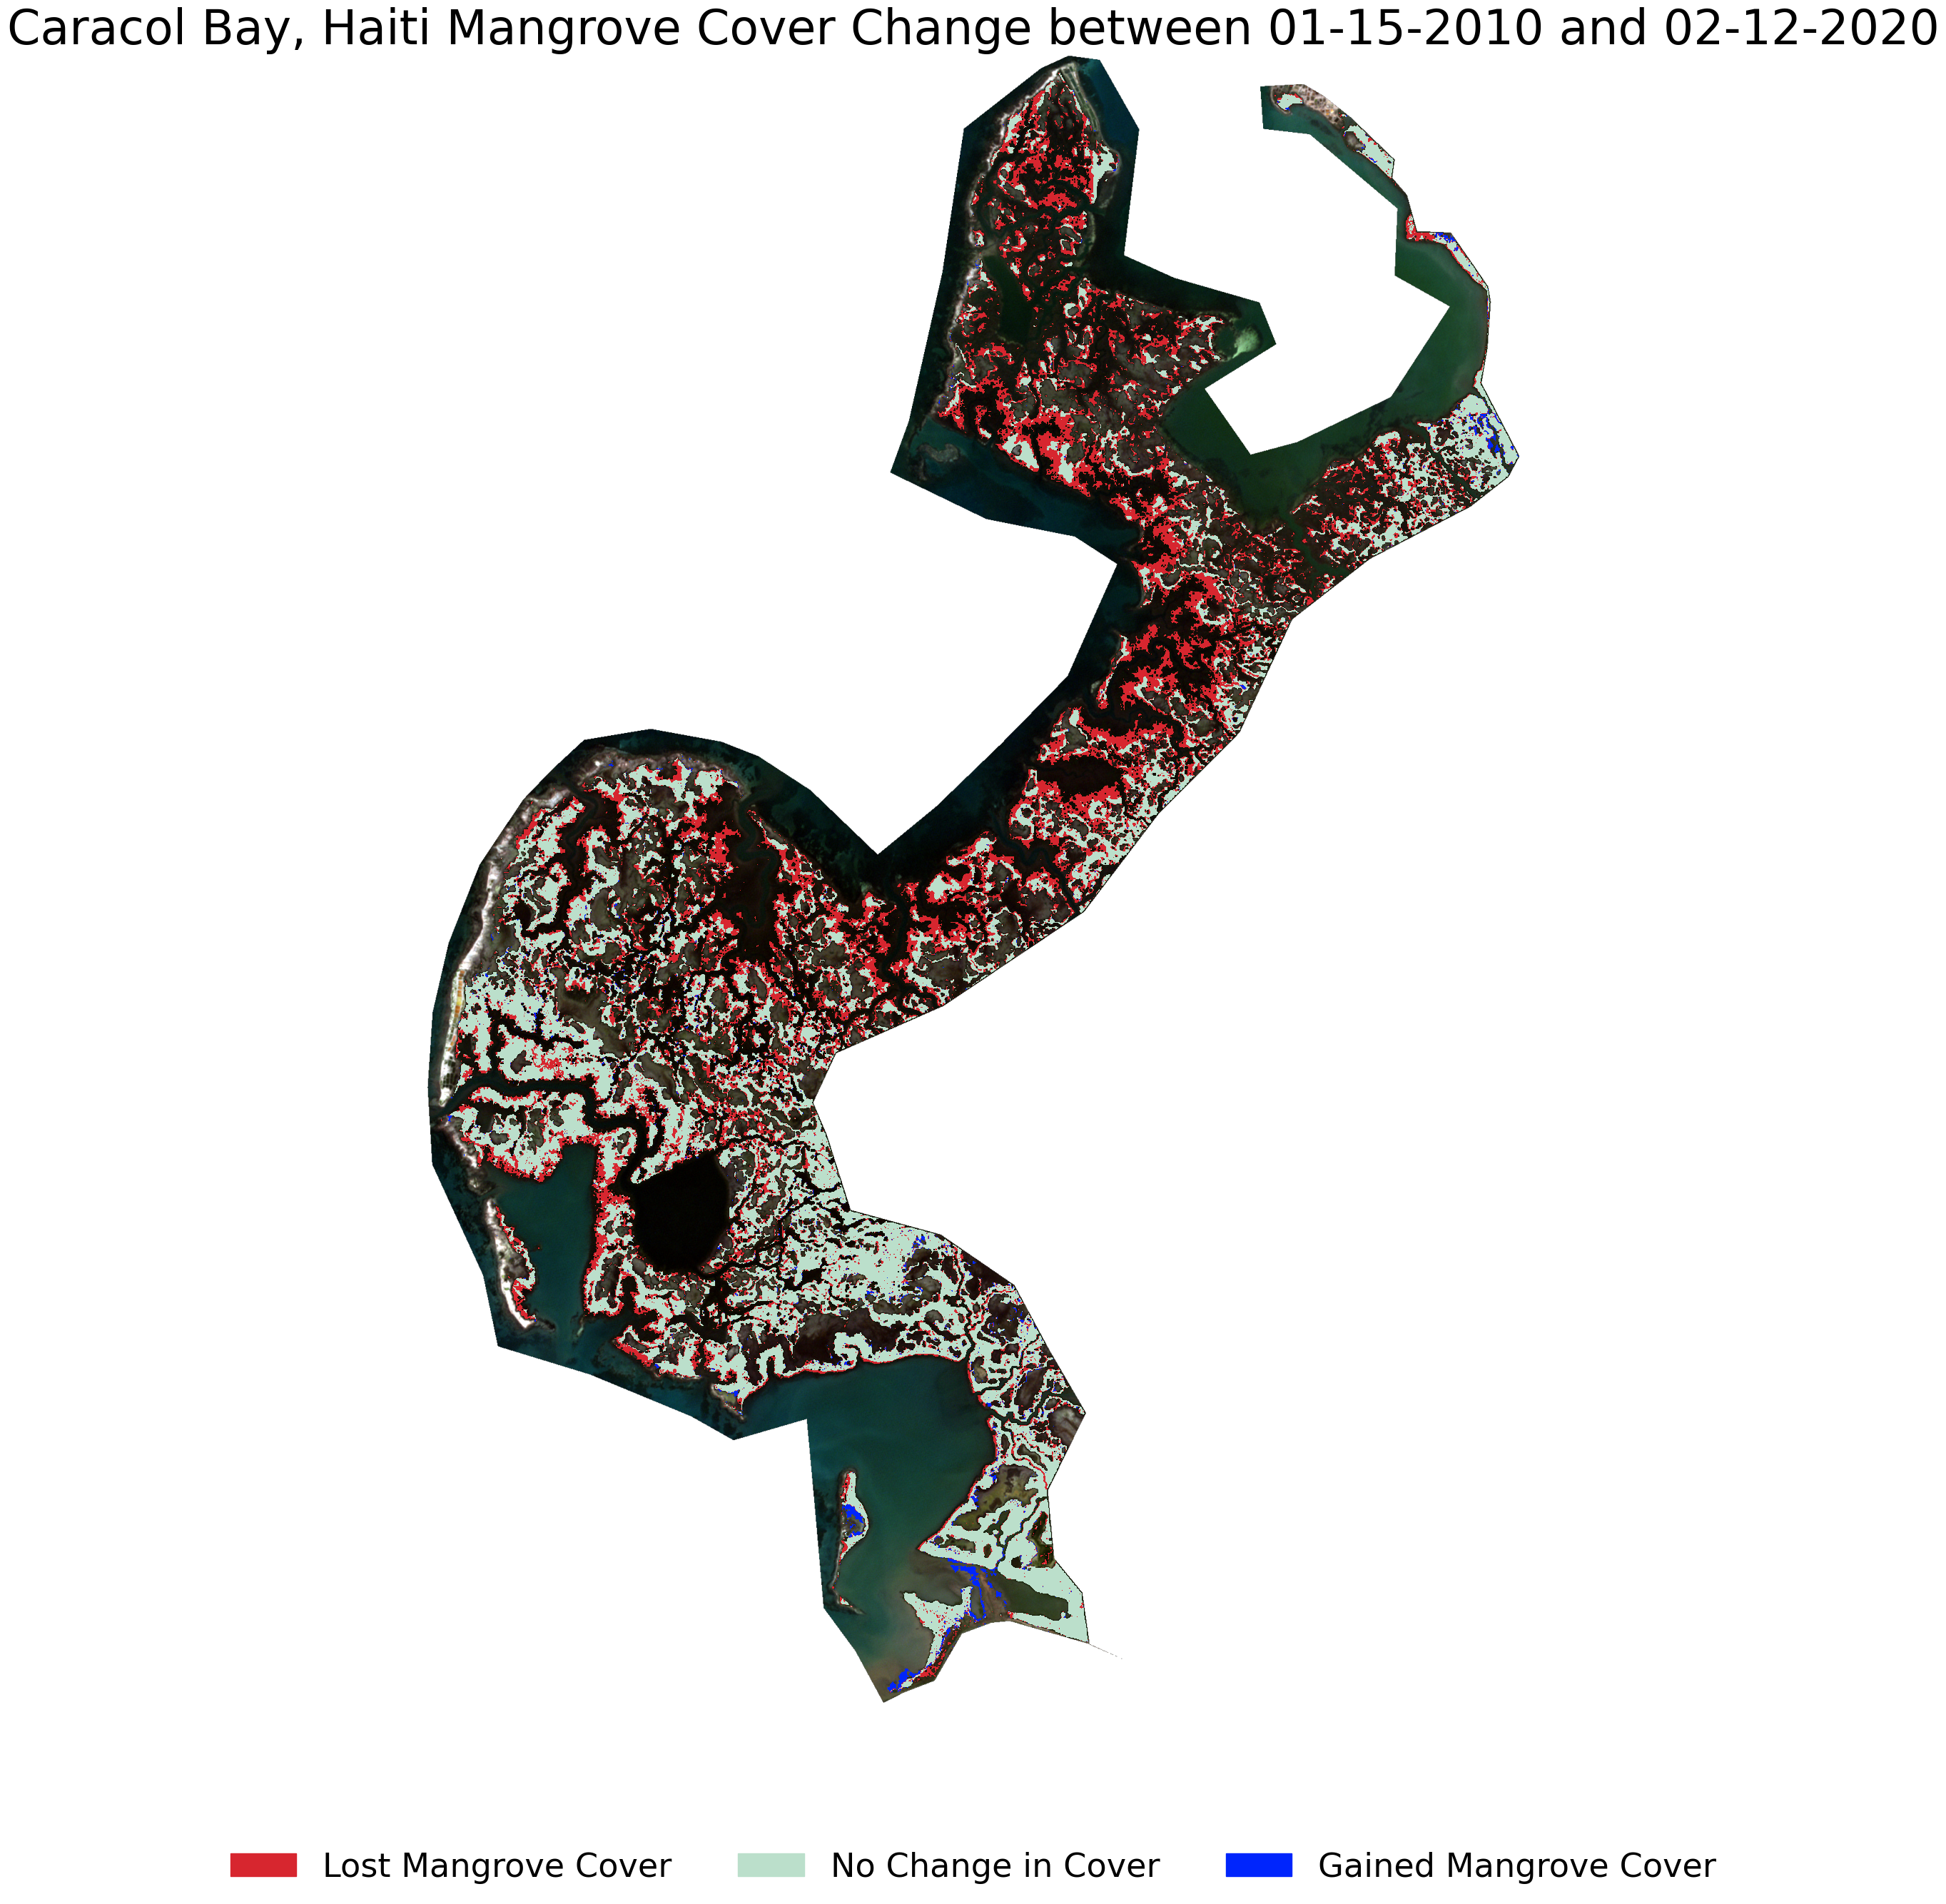

In [30]:
# Plotting Change
fig, ax = plt.subplots(figsize=(30,30), dpi=image_quality)

custom_cmap = colors_mat.ListedColormap(['#0025FC', '#D7262F', '#BBDFCB'])
boundaries = [0, 2, 4, 6]
custom_norm = colors_mat.BoundaryNorm(boundaries, custom_cmap.N, clip=True)

patches = [mpatches.Patch(color='#D7262F', label='Lost Mangrove Cover'),
            mpatches.Patch(color='#BBDFCB', label='No Change in Cover'),
            mpatches.Patch(color='#0025FC', label='Gained Mangrove Cover')]

ep.plot_rgb(base, rgb=[2,1,0], stretch=True,
            str_clip=.09, ax=ax)
ax.imshow(change_mask, cmap=custom_cmap)
ax.set_title('Caracol Bay, Haiti Mangrove Cover Change between '+times[0]+' and '+times[-1]);

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(handles=patches, fontsize='small', loc='center', bbox_to_anchor=(0.5, -0.1), fancybox=False, ncol=3, frameon=False)
ax.patch.set_facecolor('xkcd:white')

plt.show()

## Percent NDVI Change in Mangrove (dNDVI)

In [31]:
dndvi = 100*((obs[times[-1]][-1] - obs[times[0]][-1])/obs[times[0]][-1])

In [32]:
dndvi.min()

<xarray.DataArray ()>
array(-77.44635773)
Coordinates:
    band     int32 7

In [33]:
dndvi.max()

<xarray.DataArray ()>
array(298.99121094)
Coordinates:
    band     int32 7

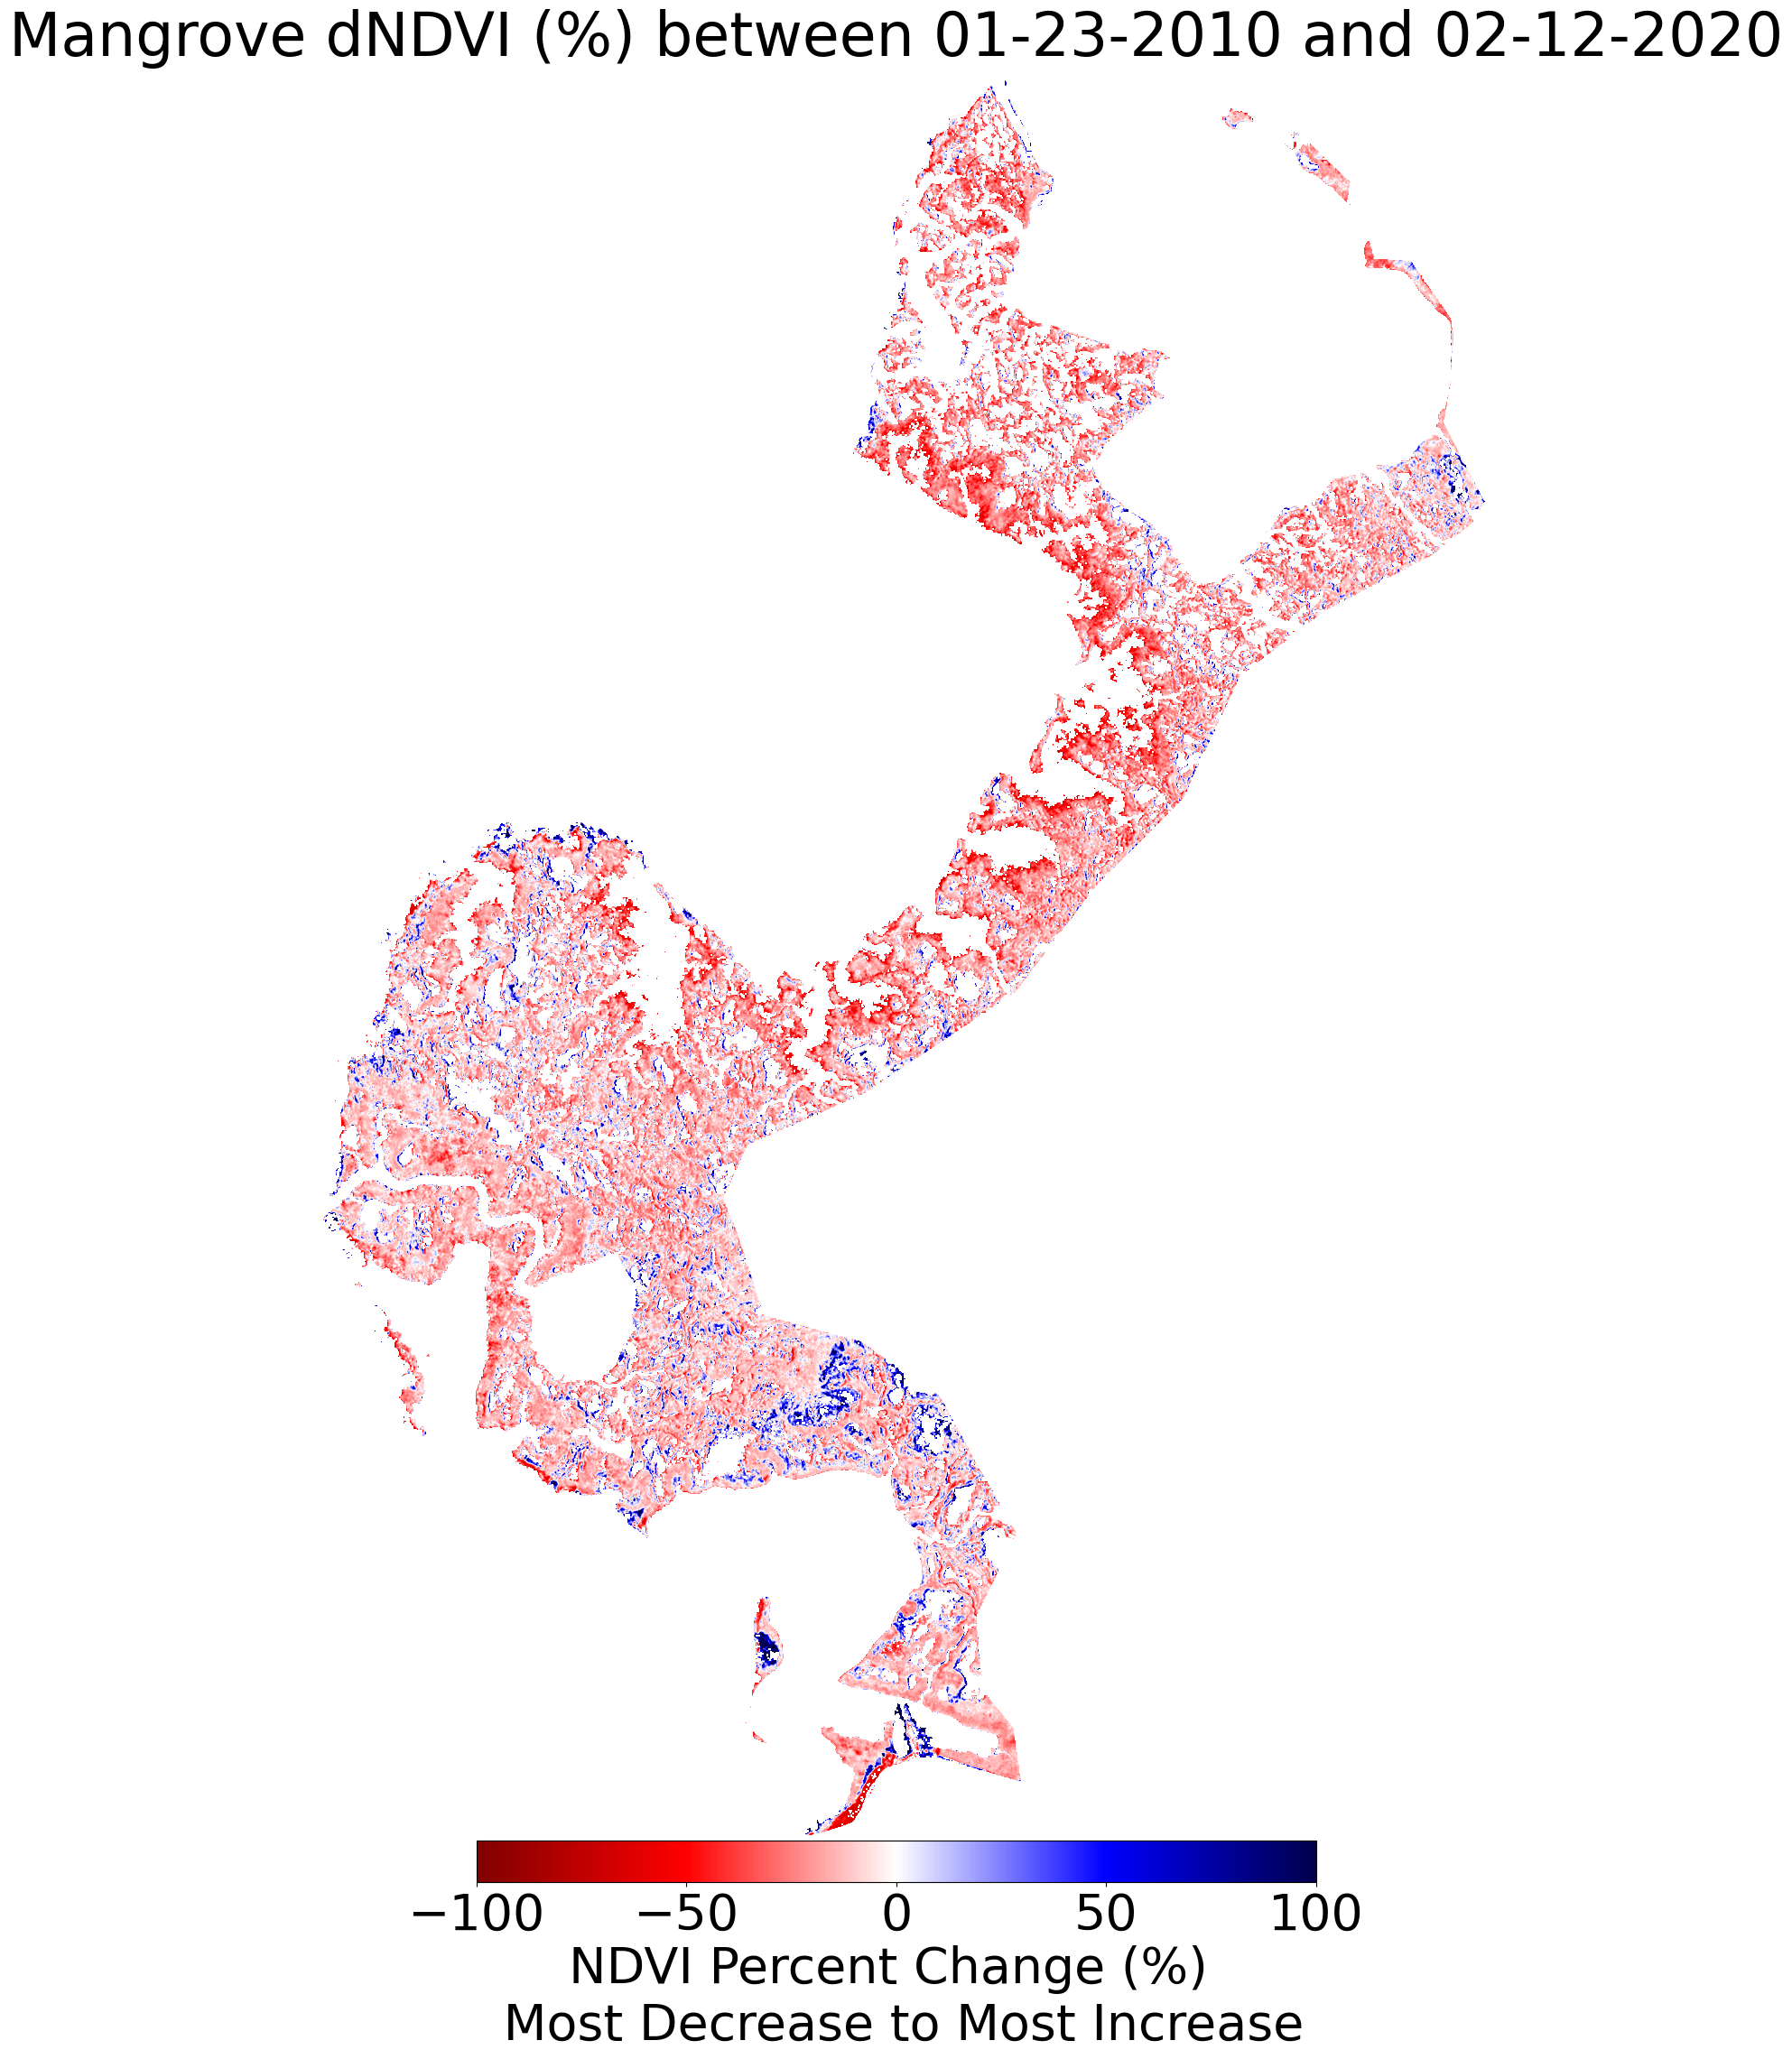

In [34]:
# Plotting Change
fig, ax = plt.subplots(figsize=(30,30), dpi=image_quality)

ax.set_title('Mangrove dNDVI (%) between '+times[1]+' and '+times[-1], loc='center')
divnorm = colors_mat.TwoSlopeNorm(vmin=-100,vcenter=0,vmax=100)

nd = ax.imshow(dndvi, cmap='seismic_r', norm=divnorm)
plt.colorbar(nd, ax=ax, location='bottom', shrink=0.4, pad=-0.0025, label='NDVI Percent Change (%) \n Most Decrease to Most Increase')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#plt.savefig('../outputs/Final Figures/dNDVI_Creative.png', dpi=1000, bbox_inches='tight', transparent=True)
plt.show()


## Trend Trajectories

In [35]:
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 32}

mpl.rc('font', **font)

In [ ]:
metrics_healthy = get_metrics([mangroveSites], times)

In [ ]:
metrics_visualization(metrics_healthy, aoi_list, 'Mangrove Cover Trajectory ('+times[0]+' to '+times[-1]+')')

## UVVR and NDVI Timeseries

### UVVR Timeseries
The unvegetated-vegetated marsh ratio (UVVR) is a spatially integrative metric that correlates with sediment budgets and sea-level rise *(Ganju et al. 2017)*; it is defined as:

$$ UVVR = \frac{A_{uv}}{A_v}$$ 

where Auv is the unvegetated area within a specified domain, and Av is the vegetated area. The total area of the wetland domain, Ad, is the sum of Auv and Av and the vegetated fraction, Fv, is therefore: <br>

$$ F_v = \frac{A_v}{A_d} $$ 

<br>
Unvegetated areas can represent bare sediment, pools, channels, and intertidal flats. Vegetated areas are typically wetland plain areas, and in a “binary” context, any vegetated plain, regardless of stem density, would be considered vegetated at some nominal spatial scale.

In [ ]:
from scipy import stats

def get_conf_int(alpha, lr, X, y):
    
    """
    Returns (1-alpha) 2-sided confidence intervals
    for sklearn.LinearRegression coefficients
    as a pandas DataFrame
    """
    
    coefs = np.r_[[lr.intercept_], lr.coef_]
    X_aux = X.copy()
    X_aux.insert(0, 'const', 1)
    dof = -np.diff(X_aux.shape)[0]
    mse = np.sum((y - lr.predict(X)) ** 2) / dof
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    t_val = stats.t.isf(alpha/2, dof)
    gap = t_val * np.sqrt(mse * var_params)

    return pd.DataFrame({
        'lower': coefs - gap, 'upper': coefs + gap
    }, index=X_aux.columns)


def linear_fit(df, site):
    # Training data
    X = df.loc[:, ['days_from_start']]  # features
    y = df.loc[:, site]  # target

    # Train the model
    model = LinearRegression()
    model.fit(X, y)

    # Store the fitted values as a time series with the same time index as
    # the training data
    y_pred = pd.Series(model.predict(X), index=X.index)

    # Confidence interval
    
    # for 95% confidence interval; use 0.01 for 99%-CI.
    alpha = 0.05
    # fit a sklearn LinearRegression model
    ci = get_conf_int(alpha, model, X, y)


    return y_pred, ci

In [ ]:
df_uvvr = uvvr_calc(times, [unvegSites], [mangroveSites], aoi_list)
df_uvvr['days_from_start'] = (df_uvvr['dates'] - df_uvvr['dates'][0]).dt.days

In [ ]:
# Dropping drought years for linear fit to ignore drought effects
#drought_points = df_NDVI_all[(df_NDVI_all['dates'] >= np.datetime64('2013-01-01')) & (df_NDVI_all['dates'] <= np.datetime64('2016-01-01'))]
#df_ndvi_drought = df_NDVI_all.drop(drought_points.index)

df_uvvr['linfit'] = linear_fit(df_uvvr, site_code)[0]
dates_backup = copy.deepcopy(df_uvvr['dates'].values)

# Convert 'dates' column to datetime
df_uvvr['dates'] = pd.to_datetime(df_uvvr['dates'])
df_uvvr.set_index('dates', inplace=True)

df_uvvr['ndates'] = dates_backup
df_uvvr['linfit'] = df_uvvr['linfit'].interpolate(method='time')
df_uvvr.head()

In [ ]:
metrics_timeseries(df_uvvr, site_code, 'Unvegetated to Vegetated Ratio Timeseries', 'Unvegetated to Vegetated Ratio')

### NDVI Timeseries

In [ ]:
df_NDVI = ndvi_calc(times, [obs], aoi_list)
df_NDVI['days_from_start'] = (df_NDVI['dates'] - df_NDVI['dates'][0]).dt.days

In [ ]:
# Dropping drought years for linear fit to ignore drought effects
#drought_points = df_NDVI_all[(df_NDVI_all['dates'] >= np.datetime64('2013-01-01')) & (df_NDVI_all['dates'] <= np.datetime64('2016-01-01'))]
#df_ndvi_drought = df_NDVI_all.drop(drought_points.index)

df_NDVI['linfit'] = linear_fit(df_NDVI, site_code)[0]
# Interpolate missing date values for fit without drought points
df_NDVI['dates'] = pd.to_datetime(df_NDVI['dates'])

dates_backup = copy.deepcopy(df_NDVI['dates'].values)


df_NDVI.set_index('dates', inplace=True)
df_NDVI['linfit'] = df_NDVI['linfit'].interpolate(method='time')

df_NDVI['ndates'] = dates_backup
df_NDVI.head()

In [ ]:
metrics_timeseries(df_NDVI, site_code, 'NDVI Timeseries', 'NDVI')

In [ ]:
df_NDVI.to_csv(CLASSIFIED_PREFIX+site_code+'_NDVI.csv')
df_uvvr.to_csv(CLASSIFIED_PREFIX+site_code+'_UVVR.csv')